In [420]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
import numpy as np
import wikipedia
import re
import nltk
from nltk.tokenize import sent_tokenize
wikipedia.WIKIPEDIA_API_URL = "https://en.wikipedia.org/w/api.php"
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
import json
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/evanthoms/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [425]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

text = "Hello. This is a test."
print(sent_tokenize(text, language='english'))

[nltk_data] Downloading package punkt to /Users/evanthoms/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/tmp/nltk_data'
**********************************************************************


In [422]:
text = "Here's a shorter version. This will give you a data structure with each individual sentence, and each token within the sentence. I prefer the TweetTokenizer for messy, real world language. The sentence tokenizer is considered decent, but be careful not to lower your word case till after this step, as it may impact the accuracy of detecting the boundaries of messy text."
list = sent_tokenize(text, language='enlish')

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/enlish/[0m

  Searched in:
    - '/tmp/nltk_data'
**********************************************************************


In [393]:
!pip freeze > req.txt


In [400]:


labels = (
    [0] * 30 +  # English = 0
    [1] * 30 +  # Spanish = 1  
    [2] * 30    # French = 2
)
words = [
    # English (30 words) - label 0
    "hello", "world", "water", "house", "book", "computer", "friend", "family", 
    "school", "teacher", "student", "learning", "reading", "writing", "speaking",
    "English", "language", "country", "people", "children", "mother", "father",
    "brother", "sister", "kitchen", "bedroom", "garden", "weather", "sunshine", "mountain",
    
    # Spanish (30 words) - label 1  
    "hola", "mundo", "agua", "casa", "libro", "computadora", "amigo", "familia",
    "escuela", "maestro", "estudiante", "aprendiendo", "leyendo", "escribiendo", "hablando",
    "español", "idioma", "país", "gente", "niños", "madre", "padre", 
    "hermano", "hermana", "cocina", "dormitorio", "jardín", "tiempo", "sol", "montaña",
    
    # French (30 words) - label 2
    "bonjour", "monde", "eau", "maison", "livre", "ordinateur", "ami", "famille",
    "école", "professeur", "étudiant", "apprenant", "lisant", "écrivant", "parlant", 
    "français", "langue", "pays", "gens", "enfants", "mère", "père",
    "frère", "soeur", "cuisine", "chambre", "jardin", "temps", "soleil", "montagne"
]

In [395]:
search_results = wikipedia.search(topic, results=1)
            if search_results:
                actual_title = search_results[0]
                print(f"Using page: '{actual_title}' for topic: '{topic}'")
                page = wikipedia.page(actual_title, auto_suggest=False)

IndentationError: unexpected indent (902151369.py, line 2)

In [414]:
wikipedia.page("History", auto_suggest=False).content[:50]

'History is the systematic study of the past, focus'

In [503]:
def clean_sentences(sentence):
    sentence = re.sub(r'\[.*?\]', '', sentence)
    sentence = re.sub(r'\[.*?\]', '', sentence)  
    sentence = re.sub(r'==.*?==', '', sentence)  
    sentence = re.sub(r'^\d+\W*$', '', sentence)
    return sentence.strip()

def get_wikipedia_sentences(language, topics, max_sentences=200):
    print("Retrieving for language ", language)
    wikipedia.set_lang(language)
    all_sentences = []
    for topic in topics:
        for attempt in range(3):
            try:
                content = wikipedia.page(topic, auto_suggest=False).content
                raw_sentences = sent_split(content)
                cleaned = [clean_sentences(i) for i in raw_sentences]
                all_sentences.extend(cleaned[:max_sentences])
                break 
            except Exception as e:
                print(f"Attempt {attempt+1} failed for topic '{topic}': {e}")
                time.sleep(2)
        else:
            print(f"Skipping topic '{topic}' after {3} failed attempts.")
    return all_sentences

def sent_split(text):
    sentences = re.split(r'[.!?]+', text)
    return [s.strip() for s in sentences if len(s) > 3]
    
def create_ngram_vocab(words, n=4):
    """Build vocabulary of all possible n-grams from training data"""
    all_ngrams=set()
    for word in words:
        marked_word = f"^{word.lower()}$"
        for i in range(len(marked_word)-n+1):
            all_ngrams.add(marked_word[i:i+n])
    return list(sorted(all_ngrams))

def word_to_ngram_features(word, vocab_dict, n=4):
    """Convert word to n-gram feature vector"""
    features = [0]*len(vocab)
    marked_word = f"^{word.lower()}$"
    for i in range(len(marked_word)-n+1):
        ngram = marked_word[i:i+n]
        idx = vocab_dict.get(ngram)
        if idx is not None:
            features[idx] += 1
    return features

class LanguageClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(128,64)
        self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(64,32)
        self.dropout3 = nn.Dropout(0.2)
        self.layer4 = nn.Linear(32,7)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer3(x))
        x = self.dropout3(x)
        x = self.layer4(x)
        return x
        
        

In [518]:

from datasets import load_dataset

talks_en = load_dataset("sentence-transformers/parallel-sentences-talks", "en-pt", split="train[:1000]")
talks_es = load_dataset("sentence-transformers/parallel-sentences-talks", "en-es", split="train[:1000]")
talks_fr = load_dataset("sentence-transformers/parallel-sentences-talks", "en-fr", split="train[:1000]")
talks_pt= load_dataset("sentence-transformers/parallel-sentences-talks", "en-pt", split="train[:1000]")
talks_it = load_dataset("sentence-transformers/parallel-sentences-talks", "en-it", split="train[:1000]")
talks_ro = load_dataset("sentence-transformers/parallel-sentences-talks", "en-ro", split="train[:1000]")



en-es/dev-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

en-es/train-00000-of-00001.parquet:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/990 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/404981 [00:00<?, ? examples/s]

en-fr/train-00000-of-00001.parquet:   0%|          | 0.00/52.0M [00:00<?, ?B/s]

en-fr/dev-00000-of-00001.parquet:   0%|          | 0.00/142k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/398870 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/992 [00:00<?, ? examples/s]

en-it/dev-00000-of-00001.parquet:   0%|          | 0.00/138k [00:00<?, ?B/s]

en-it/train-00000-of-00001.parquet:   0%|          | 0.00/46.4M [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/993 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/362809 [00:00<?, ? examples/s]

en-ro/dev-00000-of-00001.parquet:   0%|          | 0.00/140k [00:00<?, ?B/s]

en-ro/train-00000-of-00001.parquet:   0%|          | 0.00/41.0M [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/992 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/319791 [00:00<?, ? examples/s]

In [521]:
print(talks_es['non_english'][:2])
shuffled = dataset.shuffle(seed=42)
small_subset = shuffled.select(range(1000))

['Y luego hay ciertas aspectos conceptuales que pueden beneficiarse del cálculo a mano pero creo que son relativamente pocos.', 'Algo que pregunto a menudo es sobre el griego antiguo y cómo se relaciona.']


In [542]:

def write_parallel_to_file(dataset, lang):
    print("writing for lang: ",lang)
    if lang == 'en':
        sentences = dataset['english']
    else: 
        sentences= dataset['non_english']
    filename = "parallel_"+lang
    
    with open(filename, "w", encoding="utf-8") as f:
        for sent in sentences:
            f.write(sent+"\n")

write_parallel_to_file(talks_en, "en")
write_parallel_to_file(talks_es, "es")
write_parallel_to_file(talks_fr, "fr")
write_parallel_to_file(talks_pt, "pt")
write_parallel_to_file(talks_it, "it")
write_parallel_to_file(talks_ro, "ro")

writing for lang:  en
writing for lang:  es
writing for lang:  fr
writing for lang:  pt
writing for lang:  it
writing for lang:  ro


In [541]:
print(len(talks_en_shuf))

300


In [543]:
def load_parallel_sentences(lang, samp_size=300):
    filename="parallel_"+lang
    with open(filename, "r", encoding='utf-8') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
    return random.sample(lines, samp_size) if len(lines)>= samp_size else lines

parallel_sent_en= load_parallel_sentences("en")
parallel_sent_es= load_parallel_sentences("es")
parallel_sent_fr= load_parallel_sentences("fr")
parallel_sent_pt= load_parallel_sentences("pt")
parallel_sent_it= load_parallel_sentences("it")
parallel_sent_ro= load_parallel_sentences("ro")



In [544]:
print(len(parallel_sent_en))

300


In [539]:
english_sentences = get_wikipedia_sentences('en', ['History', 'Computer Science', 'Earth'])
spanish_sentences = get_wikipedia_sentences('es', ['Historia', 'Ciencia de la computación', 'Tierra'])
french_sentences  = get_wikipedia_sentences('fr', ['Histoire', 'Informatique', 'Terre'])
port_sentences = get_wikipedia_sentences('pt', ['História', 'Ciência da computação', 'Terra'])
italian_sentences = get_wikipedia_sentences('it', ['Storia','Informatica','Terra'])
romanian_sentences = get_wikipedia_sentences('ro', ['Istorie', 'Informatică', 'Pământ'])

sentences = {
    "english": english_sentences,
    "spanish": spanish_sentences,
    "french": french_sentences,
    "portuguese": port_sentences,
    "italian": italian_sentences,
    "romanian": romanian_sentences
}

with open("wiki_sentences.json", "w") as f:
    json.dump(sentences, f)


Retrieving for language  en
Retrieving for language  es
Retrieving for language  fr
Retrieving for language  pt
Retrieving for language  it
Retrieving for language  ro


In [546]:
english_sentences.extend(parallel_sent_en)
spanish_sentences.extend(parallel_sent_es)
french_sentences.extend(parallel_sent_fr)
port_sentences.extend(parallel_sent_pt)
italian_sentences.extend(parallel_sent_it)
romanian_sentences.extend(parallel_sent_ro)

In [555]:
unknown_sentences = [
    # Czech
    "Pláž je teplá a slunečná.",
    "Děti si hrají na hřišti.",
    "Mám rád českou kuchyni.",
    # Slovak
    "Dnes je krásny deň na prechádzku.",
    "Videl som pekný film včera večer.",
    "Milujem slovenské hory.",
    # Polish
    "Wczoraj poszedłem do kina z moimi przyjaciółmi.",
    "Lubię czytać polskie książki.",
    "To jest bardzo ładne miasto.",
    # Finnish
    "Tänään sataa ja on kylmä.",
    "Käyn usein kävelyllä metsässä.",
    "Pidän suomalaisesta saunasta.",
    # Hungarian
    "A kutya a kertben futkározik.",
    "Szeretek magyar ételeket enni.",
    "Ez egy szép város.",
    # Vietnamese
    "Tôi đang học tiếng Việt mỗi ngày.",
    "Hôm nay trời đẹp và nắng.",
    "Tôi thích ăn phở vào buổi sáng.",
    # Maltese
    "Il-bieraħ kien ġurnata sabiħa ħafna.",
    "Inħobb il-kċina Mediterranja.",
    "Il-belt tiegħi tinsab fuq il-baħar.",
    # Latin
    "Gallia est omnis divisa in partes tres.",
    "Veni, vidi, vici.",
    "Alea iacta est.",
    # Albanian
    "Ai është duke lexuar një libër interesant.",
    "Ne shkojmë në park çdo mëngjes.",
    "Kjo është një ditë e bukur.",
    # Esperanto
    "La hundo kuris tra la ĝardeno.",
    "Mi amas legi librojn en la parko.",
    "Hodiaŭ estas bela tago.",
    # Basque
    "Gaur eguraldi ona egingo du.",
    "Haurrak jolasten ari dira kaletan.",
    "Nire etxea herrian dago.",
    # Haitian Creole
    "Mwen kontan al lekòl chak jou.",
    "Li renmen manje diri ak pwa.",
    "Nou pral nan mache a demen.",
    # Additional Sentences
    # Galician
    "O día está soleado e quente.",
    "Gústame ler libros de historia.",
    "Os nenos xogan no parque.",
    # Norwegian (Bokmål)
    "Barna leker i hagen.",
    "Jeg liker å lese bøker.",
    "I dag er været fint.",
    # Danish
    "Børnene leger udenfor.",
    "Jeg elsker dansk mad.",
    "Det er en smuk dag i dag.",
    # Swedish
    "Jag tycker om att läsa böcker.",
    "Barnen spelar fotboll i parken.",
    "Vädret är soligt idag.",
]
unknown_labels = [6] * len(unknown_sentences)


In [558]:
import os
if os.path.exists('best_model.pth'):
    os.remove('best_model.pth')
    
inputs = []
targets = []

def split_sentences_each_lang(sents, label):
    n = len(sents)
    indices = list(range(n))
    random.shuffle(indices)
    train_idx = int(.7*n)
    val_idx = int(.85*n)
    
    
    
    train_indices = indices[:train_idx]
    val_indices = indices[train_idx:val_idx]
    test_indices = indices[val_idx:]
    return (
        [sents[i] for i in train_indices],
        [label] * len(train_indices),
        [sents[i] for i in val_indices],
        [label] * len(val_indices),
        [sents[i] for i in test_indices],
        [label] * len(test_indices))

train_sents = []
train_labels = []
val_sents = []
val_labels = []
test_sents = []
test_labels = []
train_sents.extend(unknown_sentences)
train_labels.extend(unknown_labels)




for sents, label in zip([english_sentences, spanish_sentences, french_sentences, port_sentences, italian_sentences, romanian_sentences], [0,1,2,3,4,5]):
    tr_s, tr_l, vl_s, vl_l, ts_s, ts_l = split_sentences_each_lang(sents,label)
    train_sents.extend(tr_s)
    train_labels.extend(tr_l)
    val_sents.extend(vl_s)
    val_labels.extend(vl_l)
    test_sents.extend(ts_s)
    test_labels.extend(ts_l)

vocab = create_ngram_vocab(train_sents + val_sents+test_sents)
vocab_dict = {ng: i for i, ng in enumerate(vocab)}
with open("vocab.json", "w", encoding="utf-8") as f:
    json.dump(vocab_dict, f, ensure_ascii=False, indent=2)
model = LanguageClassifier(len(vocab))

train_features = [word_to_ngram_features(s, vocab_dict) for s in train_sents]
val_features = [word_to_ngram_features(s, vocab_dict) for s in val_sents]          
test_features = [word_to_ngram_features(s, vocab_dict) for s in test_sents]



train_tensor = torch.tensor(train_features, dtype=torch.float32)
train_targets = torch.tensor(train_labels, dtype=torch.long)

val_tensor = torch.tensor(val_features, dtype=torch.float32)
val_targets = torch.tensor(val_labels, dtype=torch.long)

test_tensor = torch.tensor(test_features, dtype=torch.float32)
test_targets = torch.tensor(test_labels, dtype=torch.long)

batch_size=16
train_dataset = TensorDataset(train_tensor, train_targets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_tensor, val_targets)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


best_val_acc = 0.0
patience = 10
patience_counter =0

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001, weight_decay=.01)

def calculate_accuracy(predictions, targets):
    _, predicted = torch.max(predictions,1)
    correct = (predicted == targets).sum().item()
    return correct/len(targets)

num_epochs = 100

for epoch in range(num_epochs):

    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for batch_inputs, batch_targets in train_loader:
        #forward pass
        pred = model(batch_inputs)
        loss = loss_fn(pred, batch_targets)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += calculate_accuracy(pred, batch_targets)
    train_loss/= len(train_loader)
    train_acc/= len(train_loader)
    

    model.eval()

    val_loss = 0.0
    val_acc = 0.0
    
    with torch.no_grad():
        for batch_inputs, batch_targets in val_loader:
            val_pred = model(batch_inputs)
            v_loss = loss_fn(val_pred, batch_targets)

            val_loss+=v_loss.item()
            val_acc += calculate_accuracy(val_pred, batch_targets)
    val_loss/=len(val_loader)
    val_acc/=len(val_loader)

    if val_acc> best_val_acc:
        print("new best val acc")
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter+=1

    if epoch%2 == 0:
        print(f"Epoch: {epoch} - Train Loss: {train_loss} Acc: {train_acc} --- Val loss {val_loss} Acc: {val_acc}")

    if patience_counter>=patience:
        print("stopping early")
        break

model.load_state_dict(torch.load('best_model.pth'))

total_acc = 0
num_loops = 1
for i in range(num_loops):
    model.eval()
    with torch.no_grad():
        pred = model(test_tensor)
        acc = calculate_accuracy(pred, test_targets)
        print(f"Test Accuracy: {acc*100:.2f}%")
    total_acc+=acc
print(f"Final Accuracy: {100*total_acc/num_loops:.2f}%")
    
        
    

new best val acc
Epoch: 0 - Train Loss: 0.7546291285422113 Acc: 0.7777777777777778 --- Val loss 0.22133007645606995 Acc: 0.9583333333333334
new best val acc
Epoch: 2 - Train Loss: 0.17289427841289176 Acc: 0.9633333333333334 --- Val loss 0.16896573434739062 Acc: 0.96484375
Epoch: 4 - Train Loss: 0.1659661353089743 Acc: 0.9644444444444444 --- Val loss 0.17023605899885297 Acc: 0.9596354166666666
Epoch: 6 - Train Loss: 0.1570839797374275 Acc: 0.9638888888888889 --- Val loss 0.1751714009248341 Acc: 0.9479166666666666
Epoch: 8 - Train Loss: 0.14558772230727804 Acc: 0.9655555555555555 --- Val loss 0.15646732332728183 Acc: 0.9583333333333334
Epoch: 10 - Train Loss: 0.1340230698386828 Acc: 0.9677777777777777 --- Val loss 0.1728768057267492 Acc: 0.9505208333333334
Epoch: 12 - Train Loss: 0.13116166258437767 Acc: 0.9713888888888889 --- Val loss 0.15183036518283188 Acc: 0.96484375
stopping early
Test Accuracy: 96.59%
Final Accuracy: 96.59%


In [350]:
test_word = "it is awful"
features = word_to_ngram_features(test_word, vocab_dict)  # use vocab_dict here
input_tensor = torch.tensor([features], dtype=torch.float32)  # shape: [1, vocab_size]
pred = model(input_tensor)
lang = torch.argmax(pred).item()
print(lang)


0


In [559]:
def predict_lang(sentence, threshold=0.35):
    model.eval()
    features = word_to_ngram_features(sentence, vocab_dict)
    tensor = torch.tensor([features], dtype=torch.float32)

    with torch.no_grad():
        pred = model(tensor)
        probs = torch.softmax(pred, dim=1)
        max_prob, lang = torch.max(probs, dim=1)

        if max_prob.item()<threshold:
            return 6, max_prob.item()
        else:
            return lang.item(), max_prob.item()

label_to_language = {
    0: "English",
    1: "Spanish",
    2: "French",
    3: "Portuguese",
    4: "Italian",
    5: "Romanian",
    6: "Unknown Language"
}

test_sentences = [
    "The moon is made of rock.",
    "La computadora es muy rápida.",
    "Les enfants jouent dans le jardin.",
    "As crianças estão brincando no jardim",
    "I bambini stanno giocando in giardino.",
    "Copiii se joacă în grădină.",
    "A laila, aia ke kilokilo o nā hōkū.",
    "pláž je teplá"
    
    
]
for sent in test_sentences:
    label, conf = predict_lang(sent)
    print(f"'{sent}' -> {label_to_language[label]} Confidence: {conf:.2f}")


'The moon is made of rock.' -> English Confidence: 0.84
'La computadora es muy rápida.' -> Spanish Confidence: 0.66
'Les enfants jouent dans le jardin.' -> French Confidence: 0.96
'As crianças estão brincando no jardim' -> Portuguese Confidence: 0.80
'I bambini stanno giocando in giardino.' -> Italian Confidence: 0.77
'Copiii se joacă în grădină.' -> Romanian Confidence: 0.69
'A laila, aia ke kilokilo o nā hōkū.' -> Unknown Language Confidence: 0.19
'pláž je teplá' -> Unknown Language Confidence: 0.17


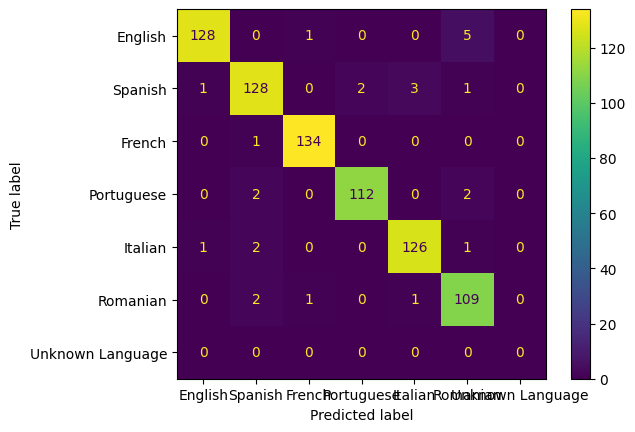

In [561]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
with torch.no_grad():
    preds = model(test_tensor)
    _, predicted = torch.max(preds, 1)
    cm = confusion_matrix(test_targets.numpy(), predicted.numpy(), labels=range(7))
    ConfusionMatrixDisplay(cm, display_labels=list(label_to_language.values())).plot()